In [1]:
import re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

## Data Loading

In [2]:
data_df = pd.read_json('./data/Sarcasm_Headlines_Dataset.json', lines=True)

print(data_df.shape)
data_df.head()

(26709, 3)


,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0


In [3]:
data_df.isnull().sum()

article_link    0
headline        0
is_sarcastic    0
dtype: int64

In [4]:
X = data_df['headline']
y = data_df['is_sarcastic'] 
print(X.shape, y.shape)

(26709,) (26709,)


## Preprocessing

In [5]:
def text_cleaning(text):
    text = re.sub(r"[^A-Za-z0-9']", " ", text) # keep single quote for sarcasm
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r'\b\d+(?:\.\d+)?\s+', '', text)
    text = text.lower()
    return text

In [6]:
count = 0
for i in range(len(X)):
    original_text = X[i]
    cleaned_text = text_cleaning(original_text)
    
    if original_text != cleaned_text:
        print("Original: ", original_text)
        print("Cleaned: ", cleaned_text)
        print("-" * 50)
        count +=1
    if count>=10: break

Original:  the 'roseanne' revival catches up to our thorny political mood, for better and worse
Cleaned:  the 'roseanne' revival catches up to our thorny political mood  for better and worse
--------------------------------------------------
Original:  mom starting to fear son's web series closest thing she will have to grandchild
Cleaned:  mom starting to fear son  web series closest thing she will have to grandchild
--------------------------------------------------
Original:  boehner just wants wife to listen, not come up with alternative debt-reduction ideas
Cleaned:  boehner just wants wife to listen  not come up with alternative debt reduction ideas
--------------------------------------------------
Original:  j.k. rowling wishes snape happy birthday in the most magical way
Cleaned:  j k  rowling wishes snape happy birthday in the most magical way
--------------------------------------------------
Original:  advancing the world's women
Cleaned:  advancing the world  women
-------

## Data Split

Class Distribution: 
 0    14985
1    11724
Name: is_sarcastic, dtype: int64


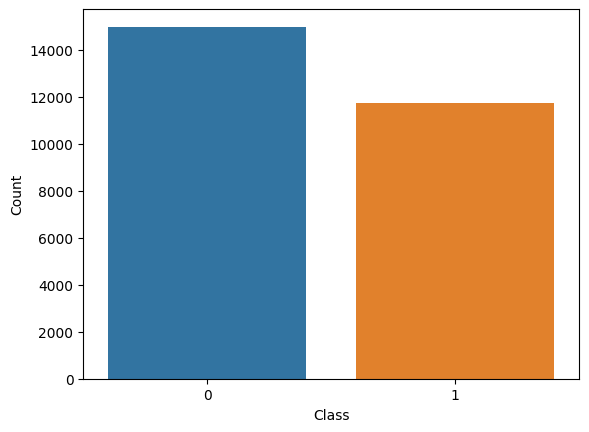

In [7]:
cd = y.value_counts()
print("Class Distribution: \n", cd)

sns.barplot(x=cd.index, y=cd.values)
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
print(f"Train: {X_train.shape} {X_test.shape} | Test: {y_train.shape} {y_test.shape}")

Train: (21367,) (5342,) | Test: (21367,) (5342,)


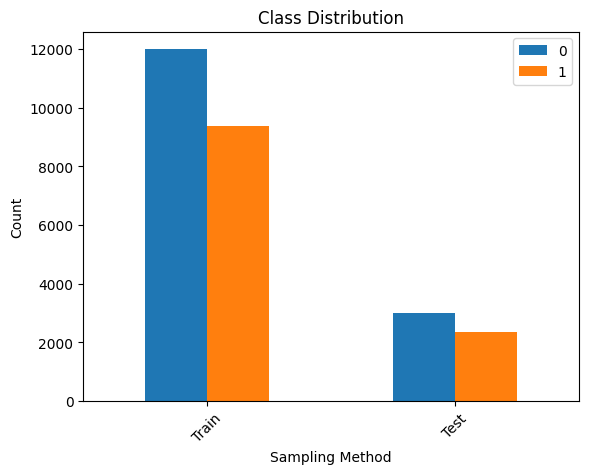

In [9]:
cd_train = y_train.value_counts()
cd_test = y_test.value_counts()

cd_df = pd.DataFrame({
    'Train': cd_train,
    'Test': cd_test,
})

cd_df.T.plot(kind='bar')
plt.title('Class Distribution')
plt.xlabel('Sampling Method')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

## Feature Extraction

In [10]:
vectorizer = TfidfVectorizer(max_features=5000, stop_words="english")
X_train_vectors = vectorizer.fit_transform(X_train)
X_test_vectors = vectorizer.transform(X_test)

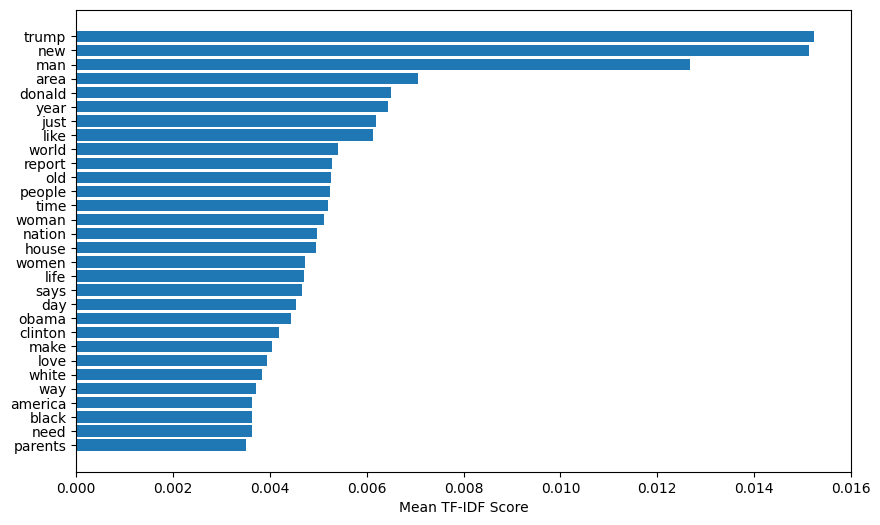

In [11]:
score_df = pd.DataFrame({"word": vectorizer.get_feature_names_out(), "mean_tfidf": X_test_vectors.mean(axis=0).A1})
top_words = score_df.nlargest(30, "mean_tfidf")

plt.figure(figsize=(10, 6))
plt.barh(top_words["word"], top_words["mean_tfidf"], align="center")
plt.gca().invert_yaxis()
plt.xlabel("Mean TF-IDF Score")
plt.show()

## Training

In [12]:
model = LogisticRegression()
model.fit(X_train_vectors, y_train)

LogisticRegression()

## Evaluation

In [13]:
y_pred = model.predict(X_test_vectors)
y_pred

array([0, 0, 1, ..., 0, 0, 0])

Accuracy: 0.7843504305503557

Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.86      0.82      2997
           1       0.80      0.68      0.74      2345

    accuracy                           0.78      5342
   macro avg       0.79      0.77      0.78      5342
weighted avg       0.79      0.78      0.78      5342



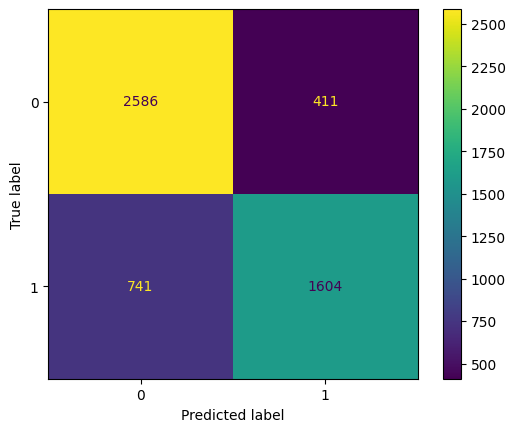

In [14]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred))
disp.plot()